In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import gensim
from tqdm import tqdm
import os

In [3]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
MAX_NB_WORDS = 50000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

## Loading the word2vec model pretrained on SEC 10K corpus 

In [6]:
cd  "/content/drive/My Drive/iiit_ire/word2vec_fasttext"

/content/drive/My Drive/iiit_ire/word2vec_fasttext


In [7]:
model_name = "./fin_word2vec"

In [8]:
model = gensim.models.Word2Vec.load(model_name)

## Loading the input datasets 

In [9]:
import json 
traind=[]
vald=[]
dir = "/content/drive/My Drive/iiit_ire/data/"
# Opening JSON file 
with open(dir+'task1_headline_ABSA_train.json',) as f: 
  traind = json.load(f) 
with open(dir+'task1_post_ABSA_train.json',) as f: 
  vald = json.load(f) 

In [10]:
"""Extract nested values from a JSON tree."""
def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [11]:
def flatten_list(k):
    result = list()
    for i in k:
        if isinstance(i,list):
            result.extend(flatten_list(i)) #Recursive call
        else:
            result.append(i)
    return result

In [12]:
aspects = json_extract(traind, 'aspects') #sentiment_score, aspects, target, sentence
sentiment_score = json_extract(traind, 'sentiment_score')
target = json_extract(traind, 'target')
sentence = json_extract(traind, 'snippets')

In [13]:
print(len(sentence), len(aspects), len(target), len(sentiment_score))

498 498 498 498


In [14]:
# initializing bad_chars_list
bad_chars = ['[', '\'', ']']
aspects = [''.join(i for i in test_string if not i in bad_chars) for test_string in aspects]
aspects = [aspect.split('/') for aspect in aspects]
aspects[:10]

[['Corporate', 'Appointment'],
 ['Corporate', 'Risks'],
 ['Corporate', 'Sales', 'Failed Contract Discussion'],
 ['Corporate', 'Appointment', 'Executive Appointment'],
 ['Corporate', 'Sales'],
 ['Stock', 'Fundamentals'],
 ['Corporate', 'Sales', 'Deal'],
 ['Corporate', 'Sales', 'Deal'],
 ['Corporate', 'Sales'],
 ['Stock', 'Technical Analysis', 'Trend', 'Trending up']]

In [15]:
flat_list = [item for sublist in aspects for item in sublist]
flat_list[:10]  

['Corporate',
 'Appointment',
 'Corporate',
 'Risks',
 'Corporate',
 'Sales',
 'Failed Contract Discussion',
 'Corporate',
 'Appointment',
 'Executive Appointment']

In [16]:
unique_aspects = set(flat_list)
print (unique_aspects, len(list(unique_aspects)) )

{'', 'Executive Reshuffle', 'Trade', 'Stock Price', 'M&A', 'Court Ruling', 'Direction', 'Corporate', 'Trending up', 'IPO', 'Corporate Planning', 'Unusual Low Volume', 'Risks', 'Conditions', 'Bullish Behaviour', 'Signal', 'Buy Signal', 'Bearish', 'Regulatory', 'Dividend going up', 'Executive Appointment', 'Monetary Policy - SNB', 'Stock Volatility', 'Price Action', 'Sale Halt', 'Mutual Fund flows', 'Failed Contract Discussion', 'Investment', 'Market Trend', 'Settlement', 'Dividend Policy', '?', 'Staff Hiring', 'Future Price', 'Sanctions', 'Buyside', 'Stock Buyside', 'Legal', 'Reputation', 'AnalystRatings', 'Bullish, Corporate', 'Partnership', 'Share Buyback', 'Insider Activity', 'Coverage', 'Bearish Behaviour', 'Bankruptcy', 'Volume', 'Dispute', 'Currency', 'Volatility', 'Company Communication', 'Trend', 'Lawsuit', 'Earnings', 'Demand Shortfall', 'Entering bankruptcy', 'Price Competition', 'Company Agreement', 'Stock', 'Sell Signal', 'Sales', 'Bullish', 'Appointment', 'Joint Venture', '

OrderedDict([('Corporate', 357), ('M&A', 106), ('Stock', 101), ('Sales', 80), ('Price Action', 58), ('Market', 54), ('Rumors', 39), ('Appointment', 37), ('Strategy', 37), ('Risks', 29), ('Dividend Policy', 28), ('Deal', 24), ('Legal', 23), ('Volatility', 19), ('Regulatory', 17), ('Proposed Merger', 16), ('Scoop', 14), ('Signal', 11), ('Company Communication', 10), ('Executive Appointment', 9), ('Fundamentals', 8), ('IPO', 8), ('Market Trend', 8), ('Reputation', 8), ('Buy Signal', 7), ('Economy', 7), ('Partnership', 7), ('Settlement', 6), ('Dividend', 6), ('Lawsuit', 6), ('Central Banks', 5), ('Investment', 5), ('Buyside', 5), ('Stock Buyside', 5), ('Technical Analysis', 4), ('Company Agreement', 4), ('Financial', 4), ('Reorganization', 4), ('Corporate Expansion', 4), ('Coverage', 4), ('Sell Signal', 4), ('Sell-Off', 4), ('Trend', 3), ('Trending up', 3), ('Corporate Planning', 3), ('Staff Hiring', 3), ('Bearish', 3), ('Bearish Behaviour', 3), ('Future Price', 3), ('Insider Activity', 3)

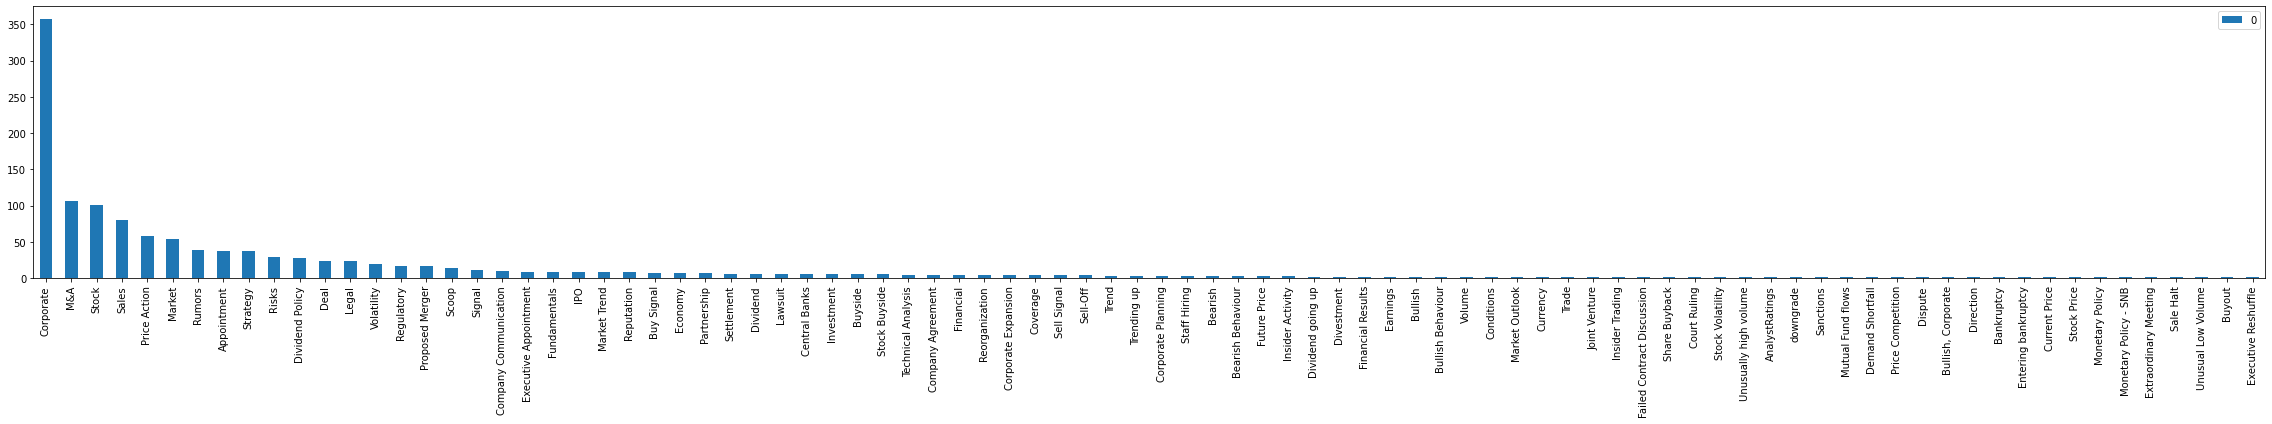

In [17]:
import collections 
counter=collections.Counter(flat_list)
counter = collections.OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
del counter['?'] 
del counter[''] 
print(counter)
df = pd.DataFrame.from_dict(counter, orient='index')
df.plot(kind='bar', figsize = (40,5))

In [18]:
bad_chars = ['[', '\'', ']']
sentence = [''.join(i for i in test_string if not i in bad_chars) for test_string in sentence]

In [19]:
#create dataframe
train = pd.DataFrame({
    'sentence': sentence, 
    'aspects': aspects, 
    'target':target, 
    'sentiment_score':sentiment_score})
train.head()

,sentence,aspects,target,sentiment_score
0,set to step down,"[Corporate, Appointment]",Royal Mail,-0.374
1,Facing Tough Competition,"[Corporate, Risks]",AstraZeneca,-0.24
2,Crest loses a third of Morrisons milk contract,"[Corporate, Sales, Failed Contract Discussion]",Morrisons,-0.161
3,hires Avivas David Hillier for multi-asset team,"[Corporate, Appointment, Executive Appointment]",Insight,0.137
4,after strong sales,"[Corporate, Sales]",Primark,0.704


In [20]:
train = train.explode('aspects')
train.head()

,sentence,aspects,target,sentiment_score
0,set to step down,Corporate,Royal Mail,-0.374
0,set to step down,Appointment,Royal Mail,-0.374
1,Facing Tough Competition,Corporate,AstraZeneca,-0.24
1,Facing Tough Competition,Risks,AstraZeneca,-0.24
2,Crest loses a third of Morrisons milk contract,Corporate,Morrisons,-0.161


In [21]:
train = train.dropna()
train = train[~train.aspects.isin(['?', ''])]
train.shape

(1267, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


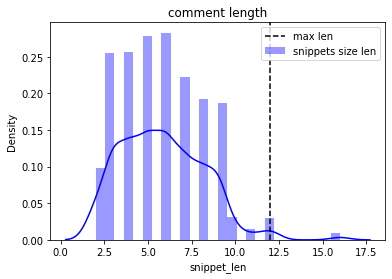

In [22]:
train['snippet_len'] = train.sentence.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train.snippet_len.mean() + 2.5*train.snippet_len.std()).astype(int)

sns.distplot(train.snippet_len, hist=True, kde=True, color='b', label='snippets size len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

### Tokenizing, sequencing and padding

In [23]:

l_train = train.sentence.tolist()

clean_train = []
clean_target = []
clean_aspects = []
clean_total = []

for doc in tqdm(l_train):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_train.append(" ".join(filtered))
  clean_total.append(" ".join(filtered))

for doc in tqdm(train.aspects.tolist()):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_aspects.append(" ".join(filtered))
  clean_total.append(" ".join(filtered))


for doc in tqdm(train.target.tolist()):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_target.append(" ".join(filtered))
  clean_total.append(" ".join(filtered))

print("Tokenizing: ")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_total)  

word_seq_train = tokenizer.texts_to_sequences(clean_train)
word_seq_target = tokenizer.texts_to_sequences(clean_target)
word_seq_aspects = tokenizer.texts_to_sequences(clean_aspects)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_target = sequence.pad_sequences(word_seq_target, maxlen=max_seq_len)
word_seq_aspects = sequence.pad_sequences(word_seq_aspects, maxlen=max_seq_len)

100%|██████████| 1267/1267 [00:00<00:00, 11959.56it/s]

Tokenizing: 
dictionary size:  1324


In [24]:
word_seq_train[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 948, 259, 458],
      dtype=int32)

In [25]:
#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [26]:
def get_embedding(word):
    try:
        embedding=model[word]
    except:
        embedding=np.zeros((embed_dim,))
    return embedding

### Creating embedding matrix

In [27]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
words_embeding_vec_none = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = get_embedding(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        if np.sum(embedding_vector) == 0:
          words_not_found.append(word)
    else:
      words_embeding_vec_none(word)

print('words_embeding_vec_none = ', len(words_embeding_vec_none))
print('vocab: %d' % np.sum(np.sum(embedding_matrix, axis=1) > 0))
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
words_embeding_vec_none =  0
vocab: 408
number of null word embeddings: 339


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
print(words_not_found[50:100])

['lehman', 'blinkbox', 'aer', 'lingus', 'novartis', 'poaches', 'off', 'severn', 'trent', 'stanchart', 'hathaway', 'brexit', 'unilever', 'wimpey', 'onemain', 'gleneagles', 'ennismore', 'axa', 'inovio', 'talktalk', 'you', 'boerse', 'asahi', 'kipa', 'whitbread', 'glaxosmithkline', 'statoil', 'u', 'k', 'acerta', 'compton', 'bphs', 'alibaba', 'â£90m', 'g', 'johnson', 'matthey', 'valeant', 'pearson', 'after', 'uks', 'pct', 'ex', 'bae', 'are', 'nps', 'omnis', 'iag', 'lonmin', 'crh']


In [29]:
train.sentiment_score

0      -0.374
0      -0.374
1       -0.24
1       -0.24
2      -0.161
        ...  
496     0.435
496     0.435
497     0.259
497     0.259
497     0.259
Name: sentiment_score, Length: 1267, dtype: object

In [30]:
train.sentiment_score = pd.to_numeric(train.sentiment_score)
train.sentiment_score

0     -0.374
0     -0.374
1     -0.240
1     -0.240
2     -0.161
       ...  
496    0.435
496    0.435
497    0.259
497    0.259
497    0.259
Name: sentiment_score, Length: 1267, dtype: float64

In [31]:
train.sentiment_score.values+1

array([0.626, 0.626, 0.76 , ..., 1.259, 1.259, 1.259])

### Building LSTM model structure

In [32]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, concatenate
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Input, TimeDistributed

In [33]:
# avoid model to overwrite
keras.backend.clear_session()

In [34]:
import tensorflow as tf
sentence_in = Input(shape=(max_seq_len, ), dtype='int32', name="sentence")
sent_embedding_layer = Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False) (sentence_in)
lstm_sentence = Bidirectional(LSTM(128))(sent_embedding_layer)



aspects_in = Input(shape=(max_seq_len,), dtype='int32', name="aspects")
aspects_embedding_layer = Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False) (aspects_in)
lstm_aspects = Bidirectional(LSTM(128))(aspects_embedding_layer)



target_in = Input(shape=(max_seq_len, ), dtype='int32', name="target")
target_in_embedding_layer = Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False) (target_in)
lstm_target = Bidirectional(LSTM(128))(target_in_embedding_layer)


x = concatenate([lstm_sentence, lstm_aspects, lstm_target])

x = Dense(1024,activation='relu')(x)
x=  Dropout(.3) (x)
x = Dense(128,activation='relu')(x)

preds = Dense(1,activation= 'linear')(x)

model = tf.keras.Model(inputs=[sentence_in, aspects_in, target_in], outputs=preds)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
aspects (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
target (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 300)      397500      sentence[0][0]                   
_______________________________________________________________________________________

In [35]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsolutePercentageError

optimizer = SGD(lr = 1e-04, momentum=.9)

model.compile(loss = MeanAbsolutePercentageError(), optimizer=optimizer, metrics=['mape'])

In [36]:
!pwd

/content/drive/My Drive/iiit_ire/word2vec_fasttext


In [37]:
#checkpoint = ModelCheckpoint('word2vec_regress_weights.best.hdf5',
#                             verbose=1,
#                             save_weights_only=True,
#                             monitor = 'val_mae',
#                             mode='min',
#                             save_best_only=True)

In [38]:
(word_seq_target)

array([[  0,   0,   0, ...,   0,  45,  93],
       [  0,   0,   0, ...,   0,  45,  93],
       [  0,   0,   0, ...,   0,   0,  13],
       ...,
       [  0,   0,   0, ...,   0,   0, 947],
       [  0,   0,   0, ...,   0,   0, 947],
       [  0,   0,   0, ...,   0,   0, 947]], dtype=int32)

In [39]:
from sklearn.model_selection import train_test_split
x_sent_train, x_sent_val, y_sent_train, y_sent_val = train_test_split(word_seq_train, train.sentiment_score.values+5,
                                                                      test_size=0.2, random_state=42) 
x_target_train, x_target_val, y_target_train, y_target_val = train_test_split(word_seq_target, train.sentiment_score.values+5,
                                                                      test_size=0.2, random_state=42) 
x_aspects_train, x_aspects_val, y_aspects_train, y_aspects_val = train_test_split(word_seq_aspects, train.sentiment_score.values+5,
                                                                      test_size=0.2, random_state=42) 

In [40]:
y_sent_train.shape, y_sent_val.shape

((1013,), (254,))

In [41]:
#es_callback = EarlyStopping(monitor='val_mae', patience=10, mode="min")
#training params
batch_size = 32 
num_epochs = 500

history = model.fit([x_sent_train, x_aspects_train, x_target_train], y_sent_train, batch_size=batch_size,
          epochs=num_epochs)#, validation_data=[[x_sent_val, x_aspects_val, x_target_val], y_sent_val])
          #callbacks=[es_callback, checkpoint])#, steps_per_epoch=train.shape[0] // batch_size,
          # shuffle=False)

Epoch 1/500
32/32 [==============================] - 1s 29ms/step - loss: 88.6542 - mape: 88.6542
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 26.2685 - mape: 26.2685
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 7.1629 - mape: 7.1629
Epoch 4/500
32/32 [==============================] - 1s 29ms/step - loss: 6.6004 - mape: 6.6004
Epoch 5/500
32/32 [==============================] - 1s 30ms/step - loss: 6.3259 - mape: 6.3259
Epoch 6/500
32/32 [==============================] - 1s 30ms/step - loss: 6.4236 - mape: 6.4236
Epoch 7/500
32/32 [==============================] - 1s 29ms/step - loss: 6.2975 - mape: 6.2975
Epoch 8/500
32/32 [==============================] - 1s 29ms/step - loss: 6.2944 - mape: 6.2944
Epoch 9/500
32/32 [==============================] - 1s 30ms/step - loss: 6.2499 - mape: 6.2499
Epoch 10/500
32/32 [==============================] - 1s 29ms/step - loss: 6.2974 - mape: 6.2974
Epoch 11/500
32/32 [===============

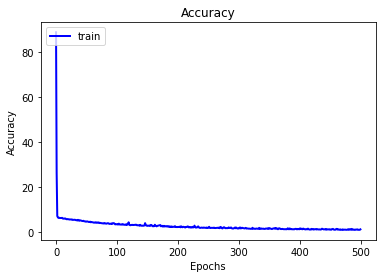

In [42]:
plt.figure()
plt.plot(history.history['mape'], lw=2.0, color='b', label='train')
#plt.plot(history.history['val_mae'], lw=2.0, color='r', label='val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [43]:
predictions = model.predict([word_seq_train, word_seq_aspects, word_seq_target])

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), (y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
mean_absolute_percentage_error(train.sentiment_score.values+5, predictions.ravel())

0.9305353873424259

In [46]:
predictions_val = model.predict([x_sent_val, x_aspects_val, x_target_val])

In [47]:
mean_absolute_percentage_error(y_sent_val, predictions_val.ravel())

1.6682302522948727

In [48]:
my_texts = tokenizer.sequences_to_texts(x_sent_val)
my_target = tokenizer.sequences_to_texts(x_target_val) 
my_aspect = tokenizer.sequences_to_texts(x_aspects_val) 

print_df = pd.DataFrame({ 'Snippet': my_texts, 'Aspect': my_aspect, 'Target': my_target,
                          'true':y_sent_val-5 , 
                         'pred': predictions_val.ravel()-5
                         })
print_df.head(20)

,Snippet,Aspect,Target,true,pred
0,3 must have growth stocks,rumors,domino 's pizza group plc,0.063,0.057656
1,lender cuts dividends shore up capita,corporate,barclays,0.261,0.167367
2,sales boost,corporate,tesco,-0.410,0.012239
3,sees baxalta deal closing expected,sales,shire,0.224,0.340776
4,can christmas save,rumors,tesco,-0.175,-0.167953
5,wipes sales gains sabmiller,corporate,sabmiller,-0.582,-0.550438
6,tesco leads leap ftse 100,technical analysis,tesco,0.389,0.385412
7,extends gas deals,deal,statoil,0.239,0.212444
8,tesco abandons video streaming ambitions,corporate,tesco,-0.335,-0.310362
9,still paying price dividend cut,corporate,l g,-0.338,-0.374923
